# Project: Youtube Adview prediction


## Prerequisites

Run to double check if all necessary libraries are already installed -

In [44]:
## Remove the --quiet flag to get more info
# ! pip install numpy pandas matplotlib seaborn sklearn keras --upgrade --quiet

To download the dataset if not already provided - <br>
You can download manually from [here](https://drive.google.com/file/d/1Dv-HF10AUUA03AO_cQvar462eXawk0iQ/view), or uncomment and run the below command and output will be saved in `test.csv` file

In [45]:
''' Run this code to download the dataset from google drive '''
''' FEEL FREE TO SAVE THIS CODE AND USE IT ANYWHERE ELSE, AS IT DOESN'T NEED ANY 3RD PARTY LIBRARIES ;) '''
# import requests

# def download_file_from_google_drive(id, destination):
#     URL = "https://docs.google.com/uc?export=download"
#     session = requests.Session()
#     response = session.get(URL, params = { 'id' : id }, stream = True)
#     token = get_confirm_token(response)
#     if token:
#         params = { 'id' : id, 'confirm' : token }
#         response = session.get(URL, params = params, stream = True)
#     save_response_content(response, destination)    

# def get_confirm_token(response):
#     for key, value in response.cookies.items():
#         if key.startswith('download_warning'):
#             return value
#     return None

# def save_response_content(response, destination):
#     CHUNK_SIZE = 32768
#     with open(destination, "wb") as f:
#         for chunk in response.iter_content(CHUNK_SIZE):
#             if chunk: # filter out keep-alive new chunks
#                 f.write(chunk)

# url = "https://drive.google.com/file/d/1Dv-HF10AUUA03AO_cQvar462eXawk0iQ/view"
# file_id = url.split('/')[5] # extract the url_id from URL
# destination = "./test.csv"
# download_file_from_google_drive(file_id, destination)

" FEEL FREE TO SAVE THIS CODE AND USE IT ANYWHERE ELSE, AS IT DOESN'T NEED ANY 3RD PARTY LIBRARIES ;) "

Import all necessary files

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Rest ML imports (sklearn and keras) are done when needed, to make it easier for you to understand their job

## Data preparation

### Information about the dataset: 


In [47]:
dataset = pd.read_csv("test.csv")
print(dataset.columns)

Index(['vidid', 'adview', 'views', 'likes', 'dislikes', 'comment', 'published',
       'duration', 'category'],
      dtype='object')


There are a number of columns in the dataset - 
1. **vidid** : Unique identification id of each video.
2. **adview** : The number of adviews for each video.
3. **views** : The number of unique views for each video.
4. **likes** : The number of likes for each video.
5. **dislikes** : The number of likes for each video.
6. **comment** : The number of unique comments for each video.
7. **published** : The data of uploading the video.
8. **duration** : The duration of the video (in min. and seconds).
9. **category** : Category niche of each of the video.

In [48]:
print(dataset.info())
# print(f"missing values: \n{data.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   vidid      14999 non-null  object
 1   adview     14999 non-null  int64 
 2   views      14999 non-null  object
 3   likes      14999 non-null  object
 4   dislikes   14999 non-null  object
 5   comment    14999 non-null  object
 6   published  14999 non-null  object
 7   duration   14999 non-null  object
 8   category   14999 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.0+ MB
None


Some columns' data types need to be changed ...

In [49]:
dataset[["views", "likes", "dislikes", "comment"]] = dataset[["views", "likes", "dislikes", "comment"]].replace("F", 0)
# dataset["views"] = dataset[dataset.views!="F"] # Another way
dataset["views"]     = pd.to_numeric(dataset["views"])
dataset["likes"]     = pd.to_numeric(dataset["likes"])
dataset["dislikes"]  = pd.to_numeric(dataset["dislikes"])
dataset["comment"]   = pd.to_numeric(dataset["comment"])
dataset["published"] = pd.to_datetime(dataset["published"])

print(dataset.dtypes)

vidid                object
adview                int64
views                 int64
likes                 int64
dislikes              int64
comment               int64
published    datetime64[ns]
duration             object
category             object
dtype: object


Assigning each category a number ...

In [50]:
category = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8}
dataset["category"] = dataset["category"].map(category)
dataset.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,6
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,4
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,3
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,8
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,4


Encoding vidid, published and duration using sklearn ...

In [51]:
# Endoding features like Category, Duration, Vidid
from sklearn.preprocessing import LabelEncoder
dataset['duration'] = LabelEncoder().fit_transform(dataset['duration'])
dataset['vidid']    = LabelEncoder().fit_transform(dataset['vidid'])
dataset['published']= LabelEncoder().fit_transform(dataset['published'])
dataset.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,6078,40,1031602,8523,363,1095,2170,2993,6
1,2869,2,1707,56,2,6,2187,3108,4
2,8339,1,2023,25,0,2,2096,1910,3
3,9215,6,620860,777,161,153,2121,2603,8
4,123,1,666,1,0,0,2093,2018,4


Label Encoder actually ruined the duration column, to make it readable we need -

In [52]:
# Convert Time_in_sec for duration
import time
def checki(x):
    y = x[2:]
    h = ''
    m = ''
    s = ''
    mm = ''
    P = ['H', 'M', 'S']
    for i in y:
        if i not in P:
            mm += i
        else:
            if(i == "H"):
                h = mm
                mm = ''
            elif(i == "M"):
                m = mm
                mm = ''
            else:
                s = mm
                mm = ''
    if(h == ''):
        h = '00'
    if(m == ''):
        m = '00'
    if(s == ''):
        s = '00'
    bp = h+':'+m+':'+s
    return bp


mp = pd.read_csv("test.csv")["duration"]
time = mp.apply(checki)


def func_sec(time_string):
    h, m, s = time_string.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)


time1 = time.apply(func_sec)
dataset["duration"] = time1
dataset.head()


,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,6078,40,1031602,8523,363,1095,2170,457,6
1,2869,2,1707,56,2,6,2187,570,4
2,8339,1,2023,25,0,2,2096,136,3
3,9215,6,620860,777,161,153,2121,262,8
4,123,1,666,1,0,0,2093,31,4


## Visualizing the data

There are 8 categories : 


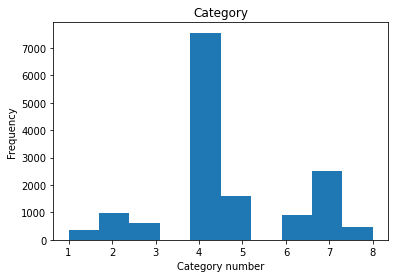

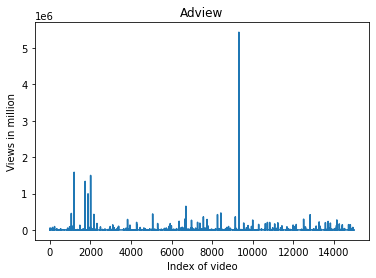

In [53]:
print("There are 8 categories : ")
plt.hist(dataset["category"])
plt.xlabel("Category number"); plt.ylabel("Frequency"); plt.title("Category")
plt.show()
plt.plot(dataset["adview"])
plt.xlabel("Index of video"); plt.ylabel("Views in million"); plt.title("Adview")
plt.show()

Here we can see that one video had abnormally high number of adviews, let's see which video is it, and we should remove it as it is an outlier.

Much better : 


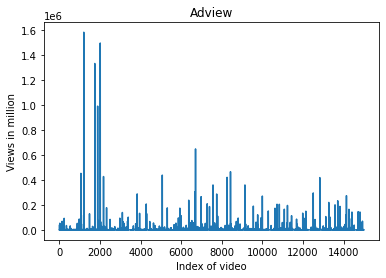

In [54]:
dataset = dataset[dataset["adview"] <2e6]
print("Much better : ")
plt.plot(dataset["adview"])
plt.xlabel("Index of video"); plt.ylabel("Views in million"); plt.title("Adview")
plt.show()

### Correlation heatmap

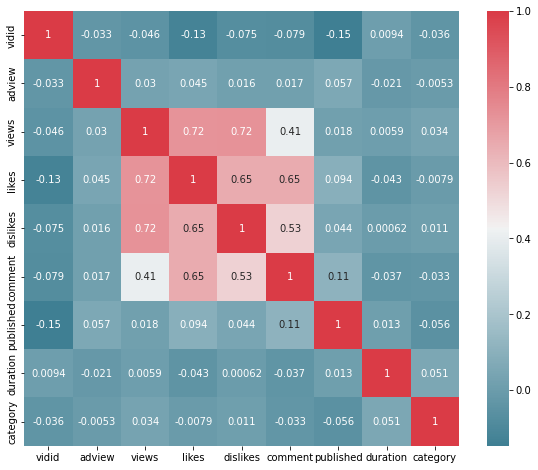

In [55]:
f, ax = plt.subplots(figsize=(10, 8))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.show()


## Machine Learning

In [56]:
# Split Data
Y_train = pd.DataFrame(data=dataset.iloc[:, 1].values, columns=['target'])
dataset = dataset.drop(["adview"], axis=1)
dataset = dataset.drop(["vidid"], axis=1)
print(dataset.head())
print(Y_train.head())
print(f"shape of dataset: {dataset.shape}")
print(f"shape of Y_train: {Y_train.shape}")

     views  likes  dislikes  comment  published  duration  category
0  1031602   8523       363     1095       2170       457         6
1     1707     56         2        6       2187       570         4
2     2023     25         0        2       2096       136         3
3   620860    777       161      153       2121       262         8
4      666      1         0        0       2093        31         4
   target
0      40
1       2
2       1
3       6
4       1
shape of dataset: (14998, 7)
shape of Y_train: (14998, 1)


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, Y_train, test_size=0.2, random_state=42)
print(X_train.head())
print(X_test.head())
print(y_train.head())
print(y_test.head())
print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_test: {y_test.shape}")


        views  likes  dislikes  comment  published  duration  category
9838   377366    308        98       22       1706      8845         4
7688   222728   5102       339      594       2104       200         6
6556     2088      2         0        1       1168       661         5
11324   17200     10         3        0        698       205         6
820     16565     31         6        1       2168        97         3
         views  likes  dislikes  comment  published  duration  category
13413    95288    219        10       11        579       339         4
6472   1043098   1640       496      117       2122       320         4
9968    728229   1088       219       59       2154      9447         4
862    1199250   4609       266      227       1638       253         4
5967    330754   1482       210     1765       1808      3328         3
       target
9837       39
7688        2
6556        1
11323       1
820      1445
       target
13412      20
6472        2
9967        1
86

In [58]:
# Normalise Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
print(X_train.mean())
print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")

0.1737401166887309
shape of X_train: (11998, 7)
shape of X_test: (3000, 7)


In [59]:
# Evaluation Metrics
from sklearn import metrics

def print_error(X_test, y_test, model_name):
    prediction = model_name.predict(X_test)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, prediction))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, prediction))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))


In [60]:
# Linear Regression
from sklearn import linear_model
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_train, y_train)
print_error(X_test,y_test, linear_regression)

Mean Absolute Error: 3516.5746519212194
Mean Squared Error: 879568906.4833322
Root Mean Squared Error: 29657.5269785485


In [61]:
# Support Vector Regressor
from sklearn.svm import SVR
supportvector_regressor = SVR()
supportvector_regressor.fit(X_train,y_train)
print_error(X_test,y_test, linear_regression)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error: 3516.5746519212194
Mean Squared Error: 879568906.4833322
Root Mean Squared Error: 29657.5269785485


In [62]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
print_error(X_test,y_test, decision_tree)

Mean Absolute Error: 2307.2556666666665
Mean Squared Error: 735978773.7516667
Root Mean Squared Error: 27128.928724733432


In [63]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
n_estimators = 200
max_depth = 25
min_samples_split = 15
min_samples_leaf = 2
random_forest = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
random_forest.fit(X_train, y_train)
print_error(X_test, y_test, random_forest)


/var/folders/vf/3kvlfy4x5ls1s64fxvnlksgm0000gn/T/ipykernel_1960/3887178697.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


Mean Absolute Error: 3062.345146581204
Mean Squared Error: 846824096.9255252
Root Mean Squared Error: 29100.242214207174


In [64]:
## Artificial Neural Network
# import keras
# from keras.layers import Dense
# ann = keras.models.Sequential([
#                                 Dense(6, activation="relu",
#                                 input_shape=X_train.shape[1:]),
#                                 Dense(6, activation="relu"),
#                                 Dense(1)
#                             ])
# optimizer = keras.optimizers.Adam()
# loss = keras.losses.mean_squared_error
# ann.compile(optimizer=optimizer, loss=loss, metrics=["mean_squared_error"])
# history = ann.fit(X_train, y_train, epochs=100)
# ann.summary()
# print_error(X_test, y_test, ann)


In [65]:
# #Saving Scikitlearn models
# import joblib
# joblib.dump(decision_tree, "decisiontree_youtubeadview.pkl")

# # Saving Keras Artificial Neural Network model
# ann.save("ann_youtubeadview.h5")

## Now we need to predict the adviews for `for_train.csv` file

You can download from [here](https://internshipstudio.com/wp-content/uploads/2020/10/test.csv)

In [66]:
# Run this if you don't already have for_train.csv ???
# url = "https://internshipstudio.com/wp-content/uploads/2020/10/test.csv"

In [67]:
validation = pd.read_csv("for_train.csv")
validation.shape
validation.sample(3)

,vidid,views,likes,dislikes,comment,published,duration,category
780,VID_734,2268503,5635,258,150,2016-02-26,PT5M29S,B
5211,VID_1660,484593,1885,109,310,2016-07-25,PT3M58S,B
2549,VID_9075,166568,242,71,11,2015-03-15,PT45M44S,D


Cleaning the validation dataset - 

In [68]:
validation[["views", "likes", "dislikes", "comment"]] = validation[["views", "likes", "dislikes", "comment"]].replace("F", 0)
# validation["views"] = validation[validation.views!="F"] # Another way
validation["views"]     = pd.to_numeric(validation["views"])
validation["likes"]     = pd.to_numeric(validation["likes"])
validation["dislikes"]  = pd.to_numeric(validation["dislikes"])
validation["comment"]   = pd.to_numeric(validation["comment"])
validation["published"] = pd.to_datetime(validation["published"])

# Map category to numbers
category = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8}
validation["category"] = validation["category"].map(category)

# Endoding features like published, Vidid
from sklearn.preprocessing import LabelEncoder
validation['vidid']    = LabelEncoder().fit_transform(validation['vidid'])
validation['published']= LabelEncoder().fit_transform(validation['published'])

# Convert Time_in_sec for duration
import time
def checki(x):
    y = x[2:]
    h = ''
    m = ''
    s = ''
    mm = ''
    P = ['H', 'M', 'S']
    for i in y:
        if i not in P:
            mm += i
        else:
            if(i == "H"):
                h = mm
                mm = ''
            elif(i == "M"):
                m = mm
                mm = ''
            else:
                s = mm
                mm = ''
    if(h == ''):
        h = '00'
    if(m == ''):
        m = '00'
    if(s == ''):
        s = '00'
    bp = h+':'+m+':'+s
    return bp


mp = pd.read_csv("for_train.csv")["duration"]
time = mp.apply(checki)


def func_sec(time_string):
    h, m, s = time_string.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)


time1 = time.apply(func_sec)
validation["duration"] = time1
validation.sample(3)


,vidid,views,likes,dislikes,comment,published,duration,category
2687,4034,10726,36,1,0,170,705,7
6471,8129,56111,156,6,11,997,327,4
4791,585,555132,652,140,255,1621,705,4


In [69]:
# Finally drop vidid column
validation_y = pd.DataFrame(data=validation.iloc[:, 1].values, columns=['target'])
validation = validation.drop(["vidid"], axis=1)
validation.shape

(8764, 7)

In [70]:
validation_test, _, validation_y_test, _  = train_test_split(validation, validation_y, test_size=0.2, random_state=42)
print(f"shape of validation_test: {validation_test.shape}")
print(f"shape of y_test: {validation_y_test.shape}")

shape of validation_test: (7011, 7)
shape of y_test: (7011, 1)


In [75]:
print("Error with linear regresson model = ")
print_error(validation_test, validation_y_test, linear_regression)
print("-"*100)
print("Error with support vector regressor model = ")
print_error(validation_test, validation_y_test, supportvector_regressor)
print("-"*100)
print("Error with decison tree regressor model = ")
print_error(validation_test, validation_y_test, decision_tree)
print("-"*100)
print("Error with random forest regressor model = ")
print_error(validation_test, validation_y_test, random_forest)
print("-"*100)
# print(f"Error with artificial neural network model = {print_error(validation, validation_y_test, ann)}")


Error with linear regresson model = 
Mean Absolute Error: 1878833980.734419
Mean Squared Error: 1.0632585868956498e+20
Root Mean Squared Error: 10311443094.424997
----------------------------------------------------------------------------------------------------
Error with support vector regressor model = 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


Mean Absolute Error: 756066.3626017892
Mean Squared Error: 15959025447475.26
Root Mean Squared Error: 3994874.8976000813
----------------------------------------------------------------------------------------------------
Error with decison tree regressor model = 
Mean Absolute Error: 756013.1657395521
Mean Squared Error: 15958944438652.723
Root Mean Squared Error: 3994864.758493424
----------------------------------------------------------------------------------------------------
Error with random forest regressor model = 
Mean Absolute Error: 716350.3352055569
Mean Squared Error: 15824255538941.398
Root Mean Squared Error: 3977971.284328407
----------------------------------------------------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
